In [22]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
import numpy as np
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score

from common.utils import load_data, mape

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")


Load energy data in Pandas Dataframe

In [23]:
data_dir = 'C:\\Users\\Bam\\Desktop\\Disertatie\\halfhourly_dataset'
energy = load_data(data_dir)[['load']]
energy.head()

,load
2012-10-12 00:30:00,0
2012-10-12 01:00:00,0
2012-10-12 01:30:00,0
2012-10-12 02:00:00,0
2012-10-12 02:30:00,0


Reduce dataframe to a month worth of data

In [24]:
start_date = '2013-08-01 00:00:00'
end_date = '2013-09-01 00:00:00'

energy = energy.loc[start_date:end_date]

The train / test split data ratio is 80% / 20%

In [25]:
train_start_date = '2013-08-01 00:00:00'
test_start_date = '2013-08-25 19:00:00'

Visualize energy data

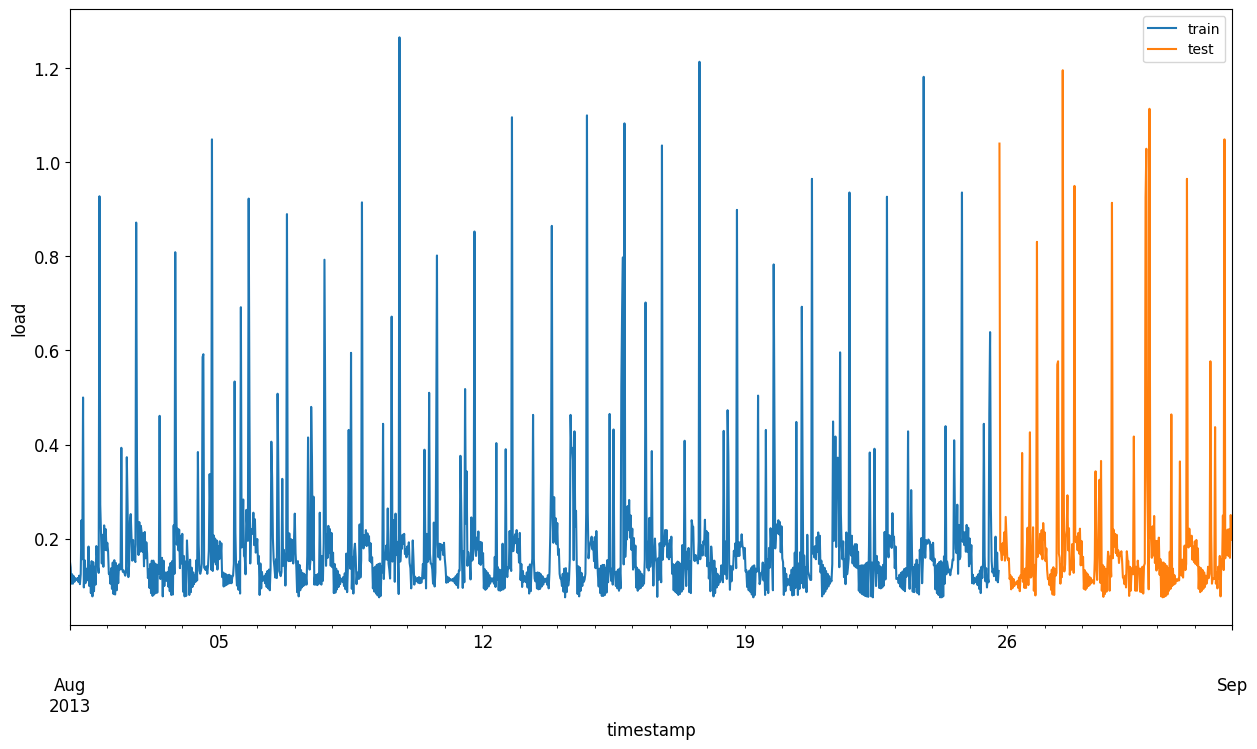

In [26]:
energy['load'] = pd.to_numeric(energy['load'])
energy[energy.index < test_start_date][['load']].rename(columns={'load':'train'}) \
    .join(energy[test_start_date:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

Load weather data from different source into Pandas Dataframe

In [27]:
weather = pd.read_csv('C:\\Users\\Bam\\Desktop\\Disertatie\\london_weather.csv')

weather['date'] = pd.to_datetime(weather['date'], format='%Y-%m-%d %H:%M')

weather.tail(2900)

,date,wind_speed,pressure,temperature,relative_humidity,precipitable_water,dew_point
0,2013-08-01 00:00:00,1.70,1012,15.80,100.00,3.10,15.80
1,2013-08-01 00:30:00,1.60,1012,15.60,100.00,3.00,15.60
2,2013-08-01 01:00:00,1.50,1012,15.40,100.00,3.00,15.40
3,2013-08-01 01:30:00,1.50,1012,15.30,100.00,3.00,15.30
4,2013-08-01 02:00:00,1.50,1011,15.10,100.00,3.00,15.10
...,...,...,...,...,...,...,...
1484,2013-08-31 22:00:00,2.40,1027,11.50,81.93,1.60,8.50
1485,2013-08-31 22:30:00,2.30,1027,11.30,83.02,1.50,8.50
1486,2013-08-31 23:00:00,2.20,1027,11.00,84.37,1.50,8.50
1487,2013-08-31 23:30:00,2.00,1027,10.60,86.64,1.50,8.50


In [28]:
# Check for missing values
missing_values = weather.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 date                  0
wind_speed            0
pressure              0
temperature           0
relative_humidity     0
precipitable_water    0
dew_point             0
dtype: int64


Energy and Weather dataset integration and interpolation.

In [29]:
weather.set_index('date', inplace=True)

weather_energy = energy.merge(weather, how='left', left_index=True, right_index=True)

weather_energy.interpolate(method='time', inplace=True)

weather_energy.head()

,load,wind_speed,pressure,temperature,relative_humidity,precipitable_water,dew_point
2013-08-01 00:00:00,0.15,1.70,1012,15.80,100.00,3.10,15.80
2013-08-01 00:30:00,0.14,1.60,1012,15.60,100.00,3.00,15.60
2013-08-01 01:00:00,0.10,1.50,1012,15.40,100.00,3.00,15.40
2013-08-01 01:30:00,0.12,1.50,1012,15.30,100.00,3.00,15.30
2013-08-01 02:00:00,0.10,1.50,1011,15.10,100.00,3.00,15.10


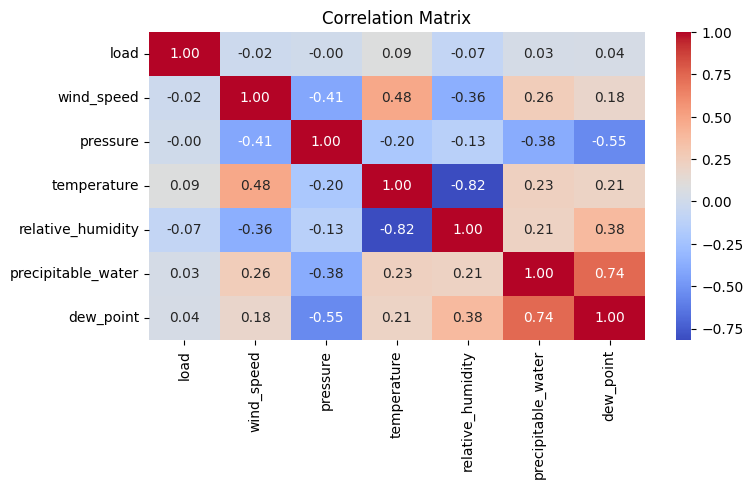

In [30]:
correlation_matrix = weather_energy.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


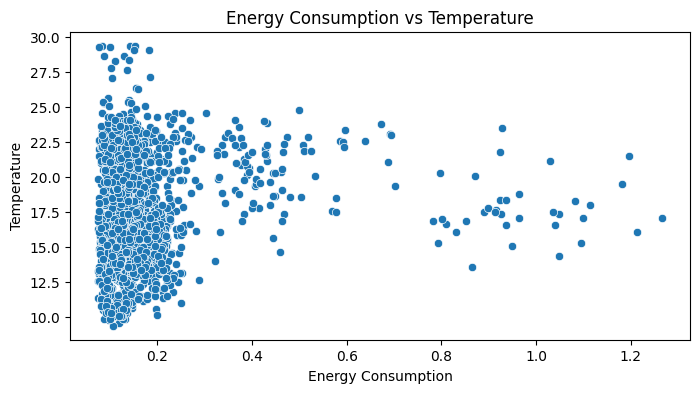

In [31]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x='load', y='temperature', data=weather_energy)
plt.title('Energy Consumption vs Temperature')
plt.xlabel('Energy Consumption')
plt.ylabel('Temperature')
plt.show()

Feature engineering

In [32]:
energy['load'] = pd.to_numeric(energy['load'], errors='coerce')
peak_threshold = energy['load'].quantile(0.90)  

bank_holidays = pd.read_csv('C:\\Users\\Bam\\Desktop\\Disertatie\\uk_bank_holidays.csv')
bank_holidays['Bank holidays'] = pd.to_datetime(bank_holidays['Bank holidays']).dt.date
bank_holiday_dates = set(bank_holidays['Bank holidays'])

# Weather features
weather_energy['temp_humidity_interaction'] = weather_energy['temperature'] * weather_energy['relative_humidity']

# Temporal features
weather_energy['hour'] = energy.index.hour
weather_energy['day_of_week'] = energy.index.dayofweek
weather_energy['month'] = energy.index.month
weather_energy['is_weekend'] = energy.index.dayofweek >= 5
weather_energy['is_peak_hour'] = np.where(energy['load'] >= peak_threshold, 1, 0)
weather_energy['is_bank_holiday'] = pd.Series(weather_energy.index.date).isin(bank_holiday_dates).values

# Lag features
weather_energy['previous_load'] = energy['load'].shift(1).fillna(0)
weather_energy['previous_is_peak_hour'] = weather_energy['is_peak_hour'].shift(1).fillna(0)
weather_energy['lag_1'] = energy['load'].shift(1).fillna(0)
weather_energy['rolling_mean_3'] = energy['load'].rolling(window=3).mean().fillna(0)
weather_energy['rolling_mean_2'] = energy['load'].rolling(window=2).mean().fillna(0)

weather_energy.head()

,load,wind_speed,pressure,temperature,relative_humidity,precipitable_water,dew_point,temp_humidity_interaction,hour,day_of_week,month,is_weekend,is_peak_hour,is_bank_holiday,previous_load,previous_is_peak_hour,lag_1,rolling_mean_3,rolling_mean_2
2013-08-01 00:00:00,0.15,1.70,1012,15.80,100.00,3.10,15.80,"1,580.00",0,3,8,False,0,False,0.00,0.00,0.00,0.00,0.00
2013-08-01 00:30:00,0.14,1.60,1012,15.60,100.00,3.00,15.60,"1,560.00",0,3,8,False,0,False,0.15,0.00,0.15,0.00,0.15
2013-08-01 01:00:00,0.10,1.50,1012,15.40,100.00,3.00,15.40,"1,540.00",1,3,8,False,0,False,0.14,0.00,0.14,0.13,0.12
2013-08-01 01:30:00,0.12,1.50,1012,15.30,100.00,3.00,15.30,"1,530.00",1,3,8,False,0,False,0.10,0.00,0.10,0.12,0.11
2013-08-01 02:00:00,0.10,1.50,1011,15.10,100.00,3.00,15.10,"1,510.00",2,3,8,False,0,False,0.12,0.00,0.12,0.11,0.11


Splitting the data into training and testing sets

In [33]:
train = weather_energy[(weather_energy.index >= train_start_date) & (weather_energy.index <= test_start_date)]
test = weather_energy[(weather_energy.index >= test_start_date)]

X_train = train.drop(columns=['load'])
y_train = train['load']

X_test = test.drop(columns=['load'])
y_test = test['load']


#model = sm.OLS(y_train, X_train).fit()
# print(model.summary())

Building, Training and Using the Model

In [34]:
def build_ann(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))  # Output layer for regression (single output)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


class KerasRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, build_fn=build_ann, epochs=50, batch_size=10, verbose=0):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = None

    def fit(self, X, y):
        input_shape = (X.shape[1],)
        self.model = self.build_fn(input_shape)
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)
        return self

    def predict(self, X):
        return self.model.predict(X)

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('selector', SelectKBest(score_func=f_regression)),
    ('ann', KerasRegressorWrapper())
])

param_grid = {
    'selector__k': [1, 3, 6],
    'ann__epochs': [50, 100],
    'ann__batch_size': [10, 20]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

y_pred = best_model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [35]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Cross-validated MSE: {-np.mean(cv_scores)}")
print(f"R2 score for testing data: {r2}")
print(f"Mean Squared Error: {mse}")
print('MAPE for testing data: ', mape * 100, '%')

Cross-validated MSE: 3.1910244937474164e-05
R2 score for testing data: 0.9983898630083651
Mean Squared Error: 4.659007930784356e-05
MAPE for testing data:  1.9465061697457522 %


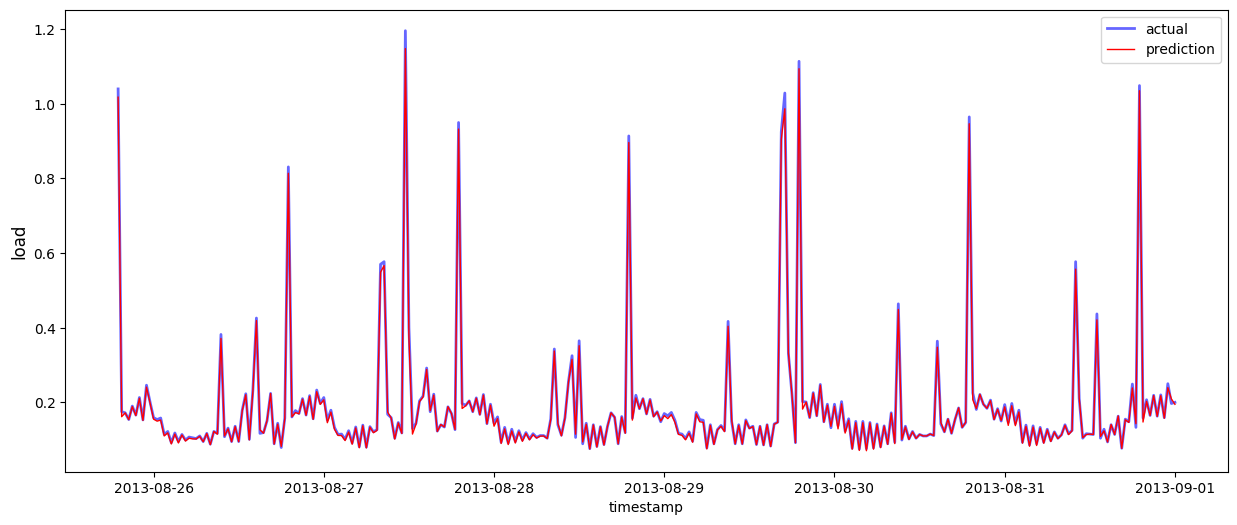

In [36]:
plt.figure(figsize=(15,6))
plt.plot(test.index, y_test, color = 'blue', linewidth=2.0, alpha = 0.6)
plt.plot(test.index, y_pred, color = 'red', linewidth=1.0)
plt.legend(['actual','prediction'])
plt.xlabel('timestamp')
plt.ylabel('load', fontsize=12)
plt.show()

In [37]:
start_date = '2013-08-01'
end_date = '2013-08-08'
filtered_data = weather_energy.loc[start_date:end_date]

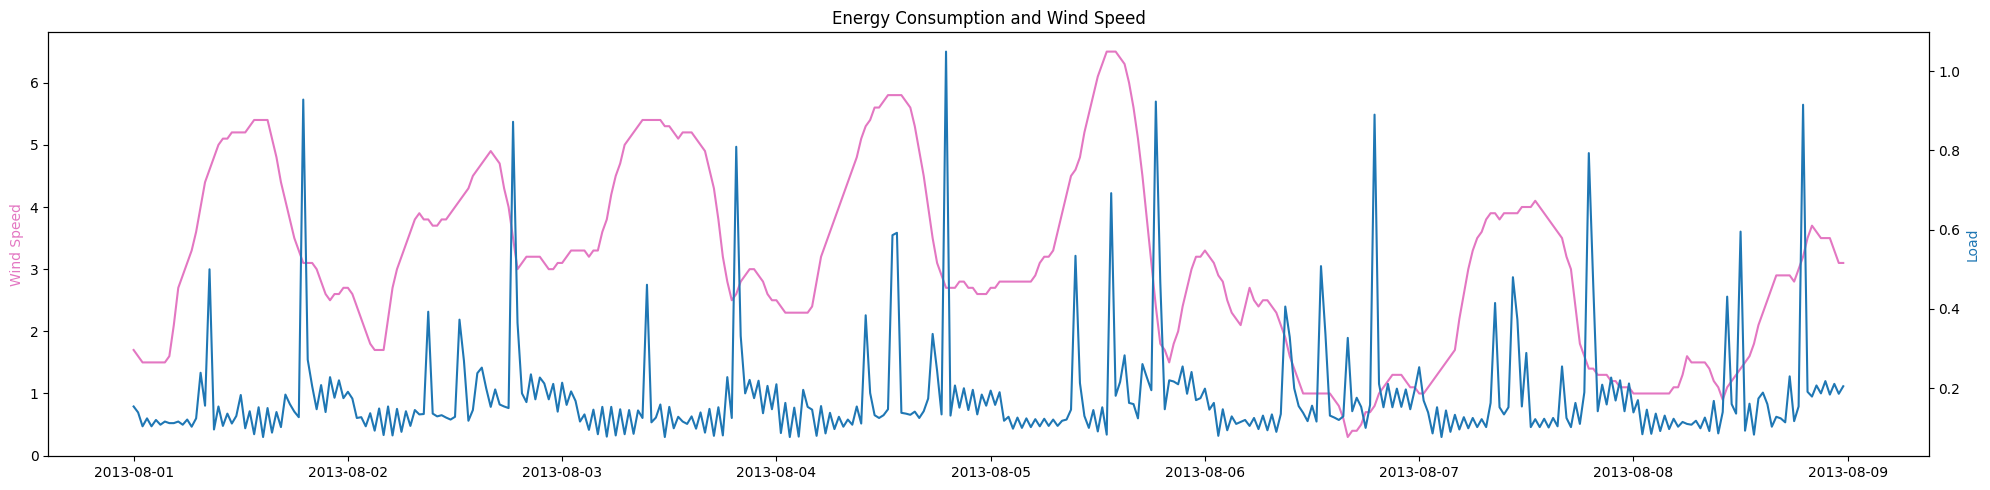

In [38]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(filtered_data.index, filtered_data.wind_speed, color = 'tab:pink')
ax1.set_ylabel('Wind Speed',color = 'tab:pink')
ax2 = ax1.twinx()
ax2.plot(filtered_data.index,filtered_data.load,color = 'tab:blue')
ax2.set_ylabel('Load',color = 'tab:blue')
plt.title('Energy Consumption and Wind Speed')
fig.tight_layout()
plt.show()

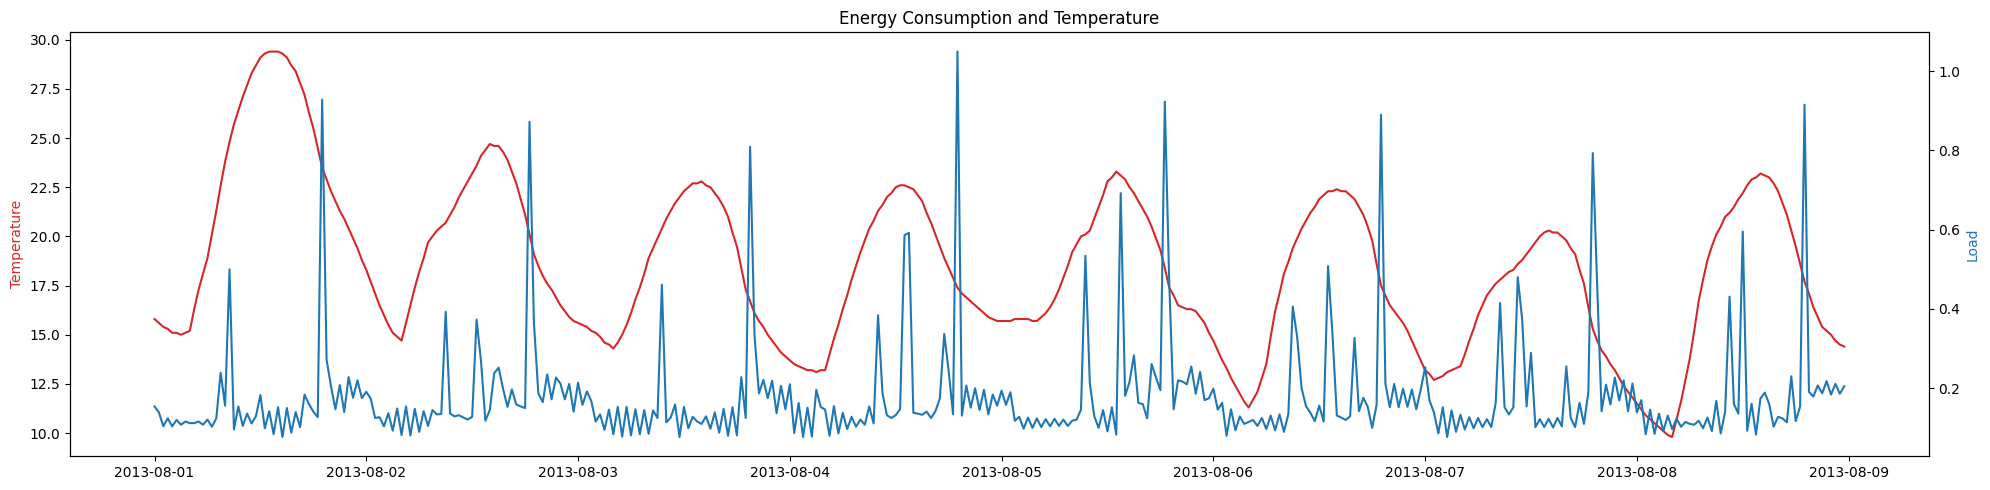

In [39]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(filtered_data.index, filtered_data.temperature, color = 'tab:red')
ax1.set_ylabel('Temperature',color = 'tab:red')
ax2 = ax1.twinx()
ax2.plot(filtered_data.index,filtered_data.load,color = 'tab:blue')
ax2.set_ylabel('Load',color = 'tab:blue')
plt.title('Energy Consumption and Temperature')
fig.tight_layout()
plt.show()

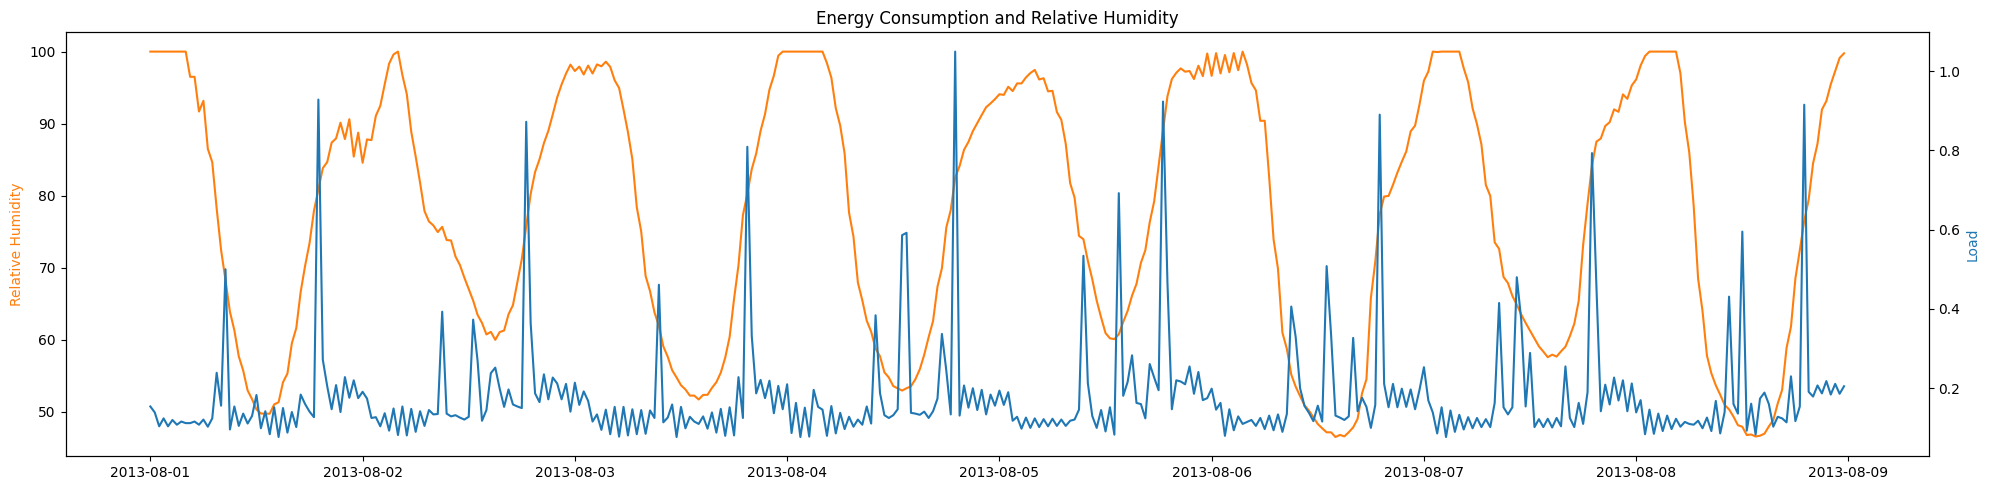

In [40]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(filtered_data.index, filtered_data.relative_humidity, color = 'tab:orange')
ax1.set_ylabel('Relative Humidity',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(filtered_data.index,filtered_data.load,color = 'tab:blue')
ax2.set_ylabel('Load',color = 'tab:blue')
plt.title('Energy Consumption and Relative Humidity')
fig.tight_layout()
plt.show()